In [23]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10, CelebA
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import torch.nn as nn
import torch
from typing import Dict, List, Set 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
BATCH_SIZE = 8
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=2)

In [4]:
classes = {i:name for i, name in enumerate(trainset.classes)}
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
imgs, labels = next(iter(trainloader))

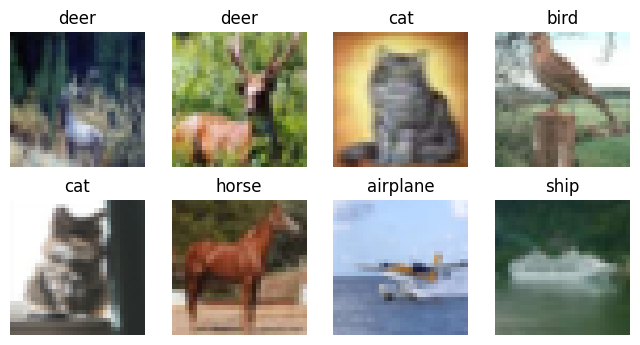

In [6]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

show_imgs(imgs, labels)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.ConvTranspose2d(in_channels=latent_dim, 
                               out_channels=256,
                               kernel_size=4, 
                               stride=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False), 
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=3,
                               kernel_size=4,
                               stride=2, 
                               padding=1, bias=False))
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int):
        super(Discriminator, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=256,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten())

        self.faker = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Flatten(),
            nn.Sigmoid())
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
            nn.Flatten(),
            nn.Softmax(dim=-1))
        
    def forward(self, input):
        extraction = self.extractor(input)
        fake_out = self.faker(extraction)
        cls_pred = self.classifier(extraction)
        return fake_out, cls_pred

In [ ]:
class ModelConfig:
    def __init__(self, batch_size, epochs, classes):
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.CLASSES = classes

class CGAN(nn.Module):
    def __init__(self, generator, discriminator, classes, params: ModelConfig):
        self.generator = generator
        self.discriminator = discriminator
        self.clases = classes
        self.params = params

    def forward(self, input):
        ...

In [12]:
input = torch.randn((8, 100))
layer = nn.Unflatten(dim=-1, unflattened_size=(100, 1, 1))
conv = nn.ConvTranspose2d(in_channels=100, out_channels=512, 
                          kernel_size=4, stride=1)
conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                           kernel_size=4, stride=2, padding=1)
conv2(conv(layer(input))).shape

torch.Size([8, 256, 8, 8])

In [22]:
disc = Discriminator(10)
f, c = disc(imgs)
f, c

(tensor([[0.5098],
         [0.5118],
         [0.4864],
         [0.5317],
         [0.5333],
         [0.5185],
         [0.5022],
         [0.5177]], grad_fn=<SigmoidBackward0>),
 tensor([[0.1122, 0.0851, 0.0998, 0.1047, 0.0942, 0.0975, 0.0973, 0.1149, 0.1001,
          0.0942],
         [0.1318, 0.0737, 0.0995, 0.1081, 0.0948, 0.1021, 0.0796, 0.1038, 0.1102,
          0.0963],
         [0.1018, 0.0870, 0.1140, 0.0957, 0.0922, 0.0961, 0.0810, 0.1088, 0.1089,
          0.1144],
         [0.1075, 0.0847, 0.1080, 0.0976, 0.0985, 0.1080, 0.0873, 0.1145, 0.1046,
          0.0892],
         [0.1154, 0.0791, 0.1103, 0.0957, 0.0929, 0.1112, 0.1008, 0.1025, 0.1078,
          0.0843],
         [0.1145, 0.0634, 0.1155, 0.0861, 0.0877, 0.1007, 0.0993, 0.1031, 0.1349,
          0.0948],
         [0.0987, 0.0863, 0.1037, 0.0969, 0.0926, 0.1014, 0.0874, 0.1114, 0.1156,
          0.1060],
         [0.1231, 0.0797, 0.1053, 0.0981, 0.0848, 0.1062, 0.0962, 0.0979, 0.1079,
          0.1007]], grad_fn=<

In [133]:
f, c

(tensor([[0.5417],
         [0.5227],
         [0.5277],
         [0.5506],
         [0.5365],
         [0.5325],
         [0.5334],
         [0.5558]], grad_fn=<SigmoidBackward0>),
 tensor([[0.1023, 0.1017, 0.1096, 0.1105, 0.1027, 0.0894, 0.0959, 0.1012, 0.0858,
          0.1009],
         [0.1082, 0.0870, 0.1001, 0.1044, 0.1286, 0.0843, 0.1042, 0.1008, 0.0856,
          0.0969],
         [0.1197, 0.0941, 0.1105, 0.1151, 0.1198, 0.0865, 0.0875, 0.0886, 0.0804,
          0.0979],
         [0.1038, 0.0825, 0.1131, 0.1205, 0.1072, 0.0863, 0.1061, 0.1045, 0.0795,
          0.0966],
         [0.1060, 0.0970, 0.0902, 0.1186, 0.1137, 0.0909, 0.0977, 0.0999, 0.0808,
          0.1050],
         [0.1165, 0.0954, 0.1018, 0.1092, 0.1140, 0.0930, 0.0974, 0.0926, 0.0797,
          0.1003],
         [0.1137, 0.0925, 0.0987, 0.1164, 0.1110, 0.0903, 0.1014, 0.0955, 0.0866,
          0.0939],
         [0.1174, 0.0903, 0.1072, 0.1135, 0.1191, 0.0885, 0.1049, 0.0862, 0.0769,
          0.0958]], grad_fn=<